In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('data/vocab.pkl')

trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 3)
trfm.load_state_dict(torch.load('.save/trfm_12_23000.pkl'))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

Total parameters: 4245037


In [390]:
def plot_mols(mols, unit=200, w=120, h=200, fontsize=1.0):
    drawer = Draw.MolDraw2DSVG(4*unit, 3*unit, w, h)

    # optをとり出しておく
    opt = drawer.drawOptions()
    opt.padding = 0.1
    opt.legendFontSize = 20
    #opt.atomfontSize = 20

    xs = np.array([0,1,2,3,0,1,2,3,0,1,2,3])*unit
    ys = np.array([0,0,0,0,1,1,1,1,2,2,2,2])*unit
    for i, (mol, x, y) in enumerate(zip(mols,xs,ys)):
        # SetOffsetで左上の座標を指定できる
        drawer.SetOffset(int(x), int(y))
        drawer.SetFontSize(fontsize)

        AllChem.Compute2DCoords(mol)
        Chem.Kekulize(mol)
        # 分子をSVGに書く
        drawer.DrawMolecule(mol, legend=str(i))


    # </svg> 書く
    drawer.FinishDrawing()
    return drawer
    

## ESOL

In [13]:
df = pd.read_csv('data/esol.csv')
print(df.shape)
df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [32]:
df = pd.read_csv('data/esol.csv')
print(df.shape)
df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [33]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [34]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)
y = df['measured log solubility in mols per litre'].values

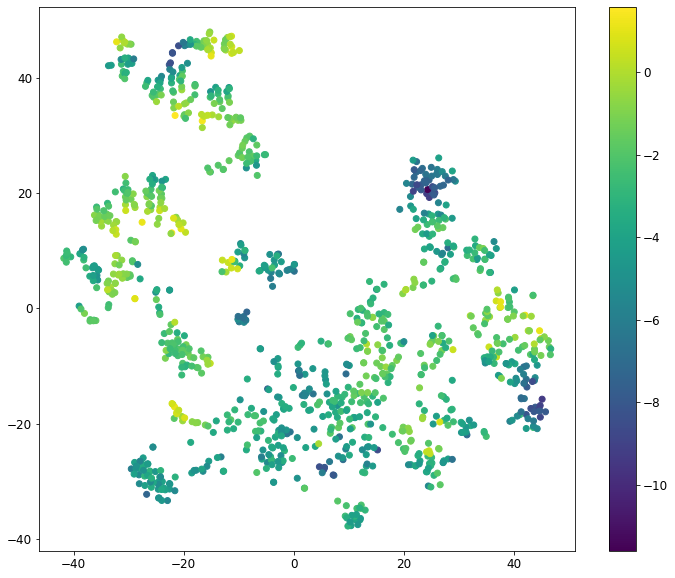

In [35]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, marker='o')
plt.colorbar()
plt.show()

## FreeSolv

In [308]:
df = pd.read_csv('data/freesolv.csv')
print(df.shape)
df.head()

(642, 4)


,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


In [309]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 642 molecules. It will take a little time.
(642, 1024)


In [310]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

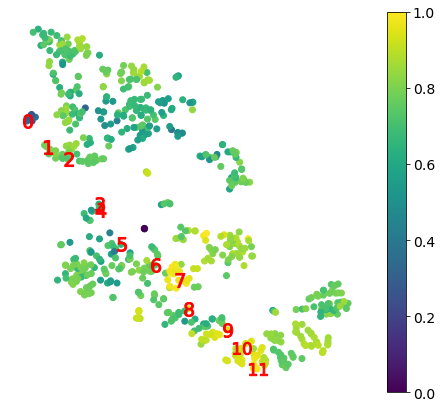

In [359]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.axis('off')
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['expt'].values, marker='o')
for i in range(12):
    plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.colorbar()
plt.savefig('freesolv.png', dpi=300)
plt.show()

In [311]:
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-24, 18, 12)
ys = np.linspace(25, -40, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

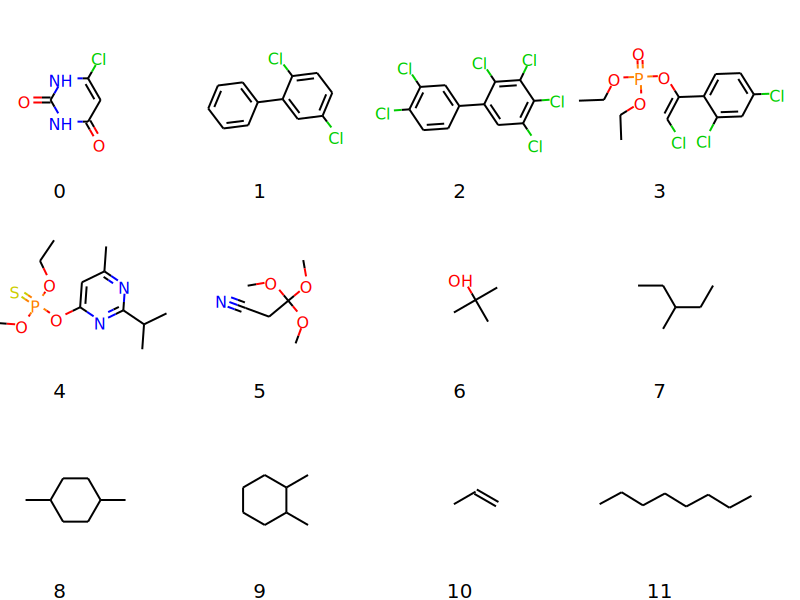

In [347]:
mols = [Chem.MolFromSmiles(sm) for sm in df['smiles'].values[ids]]
dr = plot_mols(mols)
with open('freesolv.svg', 'w') as f:
    f.write(dr.GetDrawingText())
SVG(dr.GetDrawingText())

## Lipo

In [17]:
df = pd.read_csv('data/lipo.csv')
print(df.shape)
df.head()

(4200, 3)


,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [6]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (251)
SMILES is too long (267)
There are 4200 molecules. It will take a little time.
(4200, 1024)


In [7]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)
y = df['exp'].values

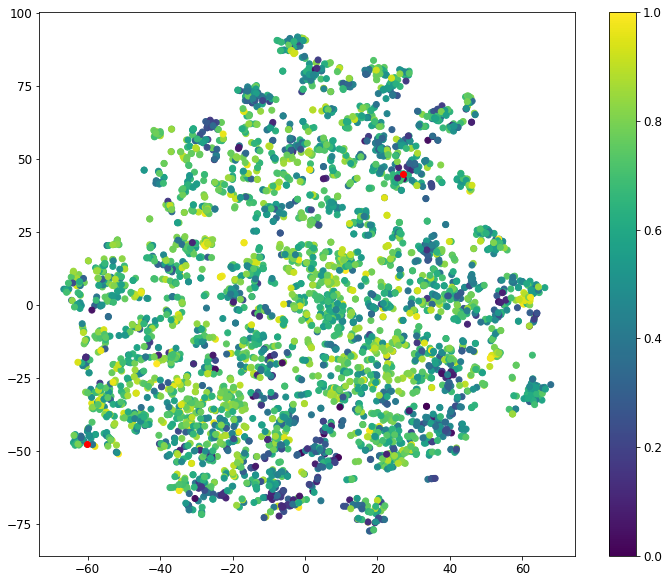

In [31]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, marker='o')
plt.scatter(X_reduced[100,0], X_reduced[100,1], c='r', marker='o')
plt.scatter(X_reduced[4197,0], X_reduced[4197,1], c='r', marker='o')
plt.colorbar()
plt.show()

In [24]:
X_reduced[100]

array([27.104004, 44.82114 ], dtype=float32)

In [19]:
X_reduced[4197]

array([-60.24972, -47.6629 ], dtype=float32)

In [18]:
df['smiles']

0                 Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1       COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2                  COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3       OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4       Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
                              ...                        
4195              OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196    CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197                                   COc1cccc2[nH]ncc12
4198                      Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3
4199                   CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N
Name: smiles, Length: 4200, dtype: object

## BBBP

In [399]:
df = pd.read_csv('data/bbbp.csv')
print(df.shape)
df.head()

(2050, 4)


,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [400]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)
There are 2050 molecules. It will take a little time.
(2050, 1024)


In [401]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

In [402]:
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

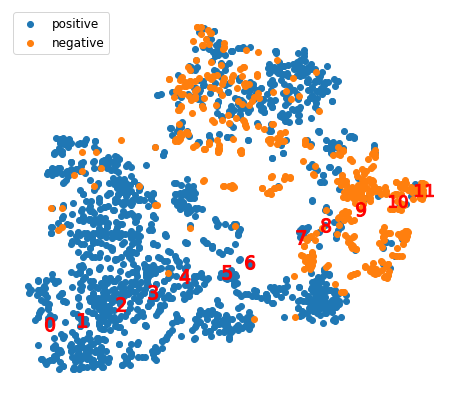

In [403]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['p_np']==1][:,0], X_reduced[df['p_np']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['p_np']==0][:,0], X_reduced[df['p_np']==0][:,1], label='negative', marker='o')
plt.axis('off')
for i in range(12):
    plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('bbbp.png', dpi=300)
plt.show()

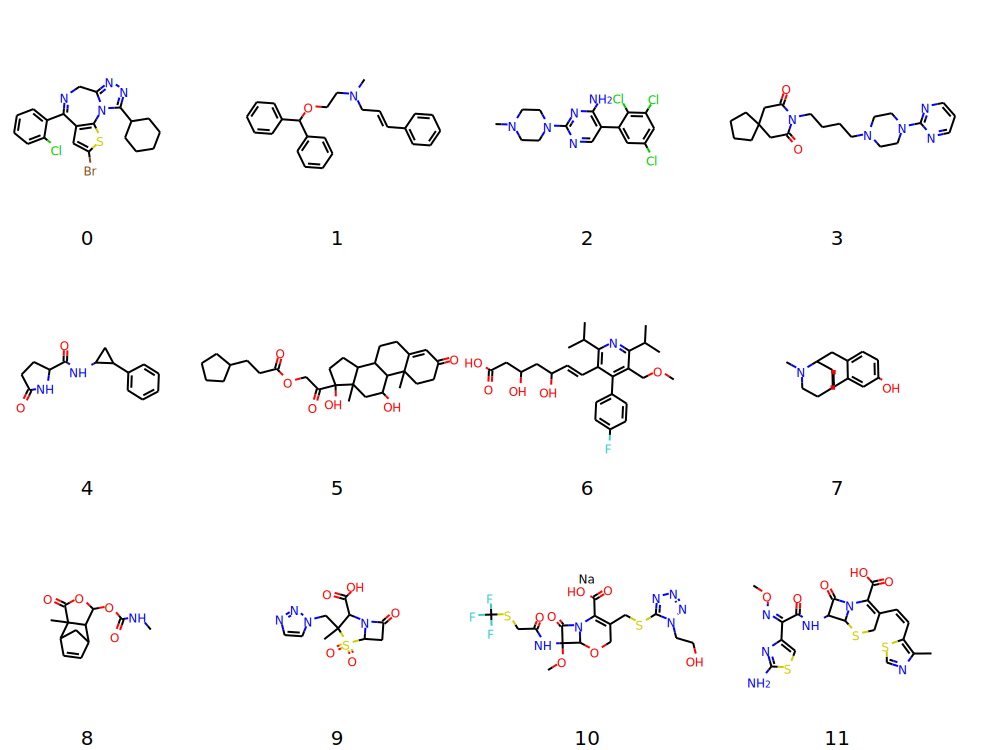

In [407]:
mols = [Chem.MolFromSmiles(sm) for sm in df['smiles'].values[ids]]
dr = plot_mols(mols, 250, 175, 250, 1.1)
with open('bbbp_mol.svg', 'w') as f:
    f.write(dr.GetDrawingText())
SVG(dr.GetDrawingText())

## ClinTox

In [408]:
df = pd.read_csv('data/clintox.csv')
KEYS  = df.keys()[1:]
print(df.shape)
df['group'] = df['FDA_APPROVED']*2 + df['CT_TOX']
df.head()

(1484, 3)


,smiles,FDA_APPROVED,CT_TOX,group
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,2
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,2
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0,2
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0,2
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0,2


In [409]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (219)
SMILES is too long (263)
SMILES is too long (318)
SMILES is too long (238)
SMILES is too long (230)
SMILES is too long (227)
SMILES is too long (261)
SMILES is too long (227)
SMILES is too long (279)
SMILES is too long (255)
SMILES is too long (271)
SMILES is too long (253)
SMILES is too long (253)
SMILES is too long (251)
SMILES is too long (221)
SMILES is too long (225)
SMILES is too long (284)
SMILES is too long (314)
SMILES is too long (236)
SMILES is too long (240)
SMILES is too long (339)
There are 1484 molecules. It will take a little time.
(1484, 1024)


In [410]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

In [411]:
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-30, 40, 12)
ys = np.linspace(40, -30, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

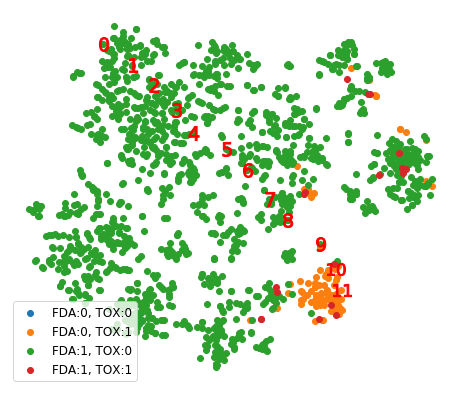

In [412]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['group']==0][:,0], X_reduced[df['group']==0][:,1], label='FDA:0, TOX:0', marker='o')
plt.scatter(X_reduced[df['group']==1][:,0], X_reduced[df['group']==1][:,1], label='FDA:0, TOX:1', marker='o')
plt.scatter(X_reduced[df['group']==2][:,0], X_reduced[df['group']==2][:,1], label='FDA:1, TOX:0', marker='o')
plt.scatter(X_reduced[df['group']==3][:,0], X_reduced[df['group']==3][:,1], label='FDA:1, TOX:1', marker='o')
plt.axis('off')
for i in range(12):
    plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend( loc='lower left')
plt.savefig('clintox.png', dpi=300)
plt.show()

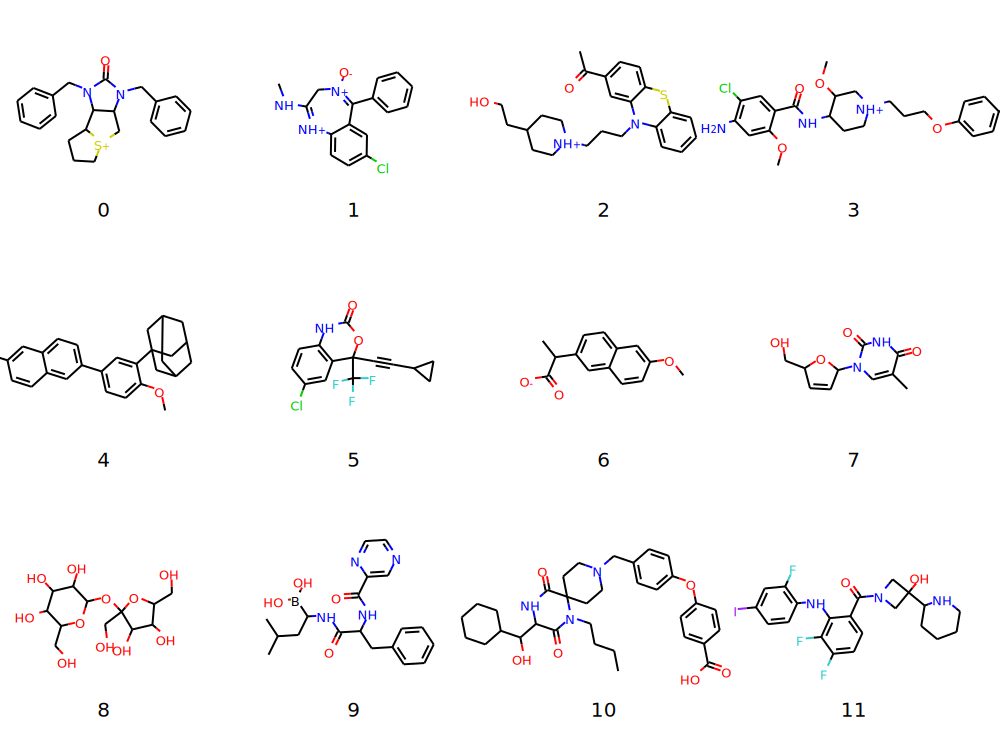

In [413]:
mols = [Chem.MolFromSmiles(sm) for sm in df['smiles'].values[ids]]
dr = plot_mols(mols, 250, 208, 220, 1)
with open('clintox_mol.svg', 'w') as f:
    f.write(dr.GetDrawingText())
SVG(dr.GetDrawingText())